# Gaussian Mixture Models

## Base teórica

Nesse notebook, veremos a estimativa de densidade com o Modelo de Misturas de Gaussianas, o Gaussian Mixture Model. Iremos entender a matemática por trás desse modelo probabilístico, quais são seus parâmetros e como ele aprende.

Os Modelos de Misturas são usados para descrever uma distribuição $p(x)$ por uma combinação de $K$ distribuições de probabilidades
$$
p(x) = \sum_{i=1}^{K}\phi_i \space p_i(x), \quad 0 \le \phi_i \le 1, \quad \sum_{i=1}^{K}\phi_i = 1,
$$

onde os componentes $p_i$ são membros de uma família de distribuições básicas, como Gaussianas, Binomiais, Gammas, e $\phi_i$ são os *pesos da mistura*. 

No Modelo de Misturas de Gaussianas, utiliza-se a combinação de $K$ distribuições Gaussianas $\mathcal{N}(x|\space \mu_i, \space \sigma_i^2)$ de tal forma que

$$
p( x| \theta) = \sum_{i=1}^{K}\phi_i \space \mathcal{N}(x_i|\space \mu_i, \space \sigma_i^2),
$$

$$
\mathcal{N}(x_i|\space \mu_i, \space \sigma_i^2) = \frac{1}{\sigma_i \sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x_i-\mu_i}{\sigma_i})^2}, \quad 0 \le \phi_i \le 1, \quad \sum_{i=1}^{K}\phi_i = 1, \quad 
$$

onde:

- $\mu$: média,
- $\sigma$: desvio padrão,
- $x$ é uma variável aleatória,
- e definimos $\theta := \{ \mu_i, \sigma_i, \phi_i \space : \space i=1, ..., K \}$ como a coleção de todos os parâmetros do modelo. 


Essa combinação de distribuição de Gaussianas nos traz mais flexibilidade para modelar densidades complexas que uma única e simples distribuição Gaussiana. 

O desafio agora é: como ajustar os parâmetros das Gaussianas (conjunto $\theta$) de forma a obter o melhor ajuste aos dados presentes? É claro que, se soubéssemos que componente gerou cada ponto dos dados, seria fácil recuperar as distribuições gaussianas correspondentes: poderíamos simplesmente selecionar todos os pontos de dados a partir de um dado componente e depois aplicar (em uma versão multivariada) a Equação: para ajustar os parâmetros de um gaussiano a um conjunto de dados. Por outro lado, se os parâmetros de cada componente fossem conhecidos, poderíamos, pelo menos em um sentido probabilístico, atribuir cada ponto de dados a um componente. O problema é que nao conhecemos nem as atribuições nem os parâmetros.

A ideia básica do EM é fingir que conhecemos os parâmetros do modelo e depois deduzir a probabilidade de cada ponto de dados pertencer a cada componente. Depois disso, readptamos os componentes aos dados, onde cada componente é ajustado ao conjunto de dados inteiro, com cada ponto ponderado pelo probabilidade de pertencer a esse componente. O processo iterage até a convergência. Essencialmnete, estamos "completando" os dados, deduzindo distribuições de probabilidade sobre as variáveis ocults - o com componente ao qual pertence cada ponto de dados - com base no modelo atual. Para o GMM, inicializamos arbitrariamente os paramentros do modelo de mistura e depois repitimos as duas etapas a seguir: 
1. Etapa E:
2. Etapa M: 

## Implementação em código

Nessa parte do notebook, a ideia é produzir dados artificialmente a partir de $3$ distribuiçoes Gaussianas e treinar, com base no algoritmo de Maximação de Expectativa, EM Algorithm, um modelo de misturas de Gaussianas - GMM - que melhor se ajusta a esses dados.

In [1]:
# Bibliotecas

import numpy as np
from scipy.stats import multivariate_normal
from scipy.linalg import norm

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

### Criando dados artificias

In [2]:
# Definindo vetor de médias e covariâncias

K = 3  # número de componentes

## Médias
m = np.zeros((3, 2))
m[0] = np.array([1.2, 0.4])
m[1] = np.array([-4.4, 1.0])
m[2] = np.array([4.1, -0.3])

## Covariâncias
S = np.zeros((3, 2, 2))
S[0] = np.array([[0.8, -0.4], [-0.4, 1.0]])
S[1] = np.array([[1.2, -0.8], [-0.8, 1.0]])
S[2] = np.array([[1.2, 0.6], [0.6, 3.0]])

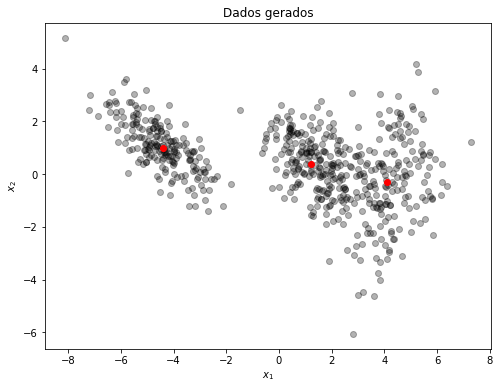

In [3]:
N_gaussian = 200  # número de pontos por gaussiana (componente da mistura)
N = N_gaussian*K  # número total de pontos
x = []
y = []

for k in range(K):
    x_temp, y_temp = np.random.multivariate_normal(m[k], S[k], N_gaussian).T
    x = np.hstack([x, x_temp])
    y = np.hstack([y, y_temp])

data = np.vstack([x, y])

# Plotando o dataset
plt.figure(figsize=(8, 6))
plt.title('Dados gerados')
plt.plot(x, y, 'ko', alpha=0.3)  # dados gerados
plt.plot(m[:,0], m[:,1], 'or')   # médias definidas anteriormente
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

### Algoritmo EM

#### Inicializando parâmetros e visualizando as Gaussianas iniciais

In [5]:
## Iniciando os parâmetros (médias, covariâncias e pesos) do EM arbitrariamente

medias = np.zeros((K, 2))
covs   = np.zeros((K, 2, 2))

for k in range(K):
    medias[k] = np.random.normal(size=(2,))
    covs[k]   = np.eye(2)

pesos = np.ones((K, 1))/K

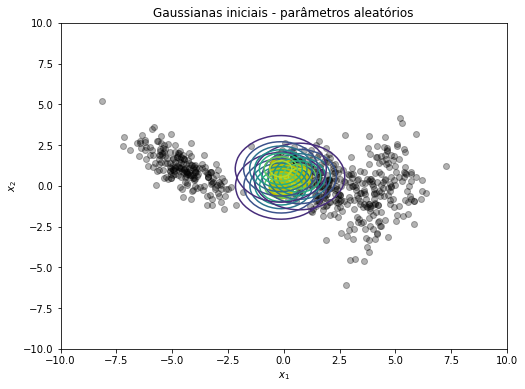

In [6]:
## Visualizando as Gaussianas criadas

plt.figure(figsize=(8, 6))
plt.plot(x, y, 'ko', alpha=0.3)
plt.plot(medias[:,0], medias[:,1], 'oy', markersize=25)

X, Y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
pos = np.dstack((X, Y))

for k in range(K):
    rv = multivariate_normal(mean=medias[k,:],cov=covs[k,:,:])
    plt.contour(X, Y, rv.pdf(pos), alpha=1.0, zorder=10)

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Gaussianas iniciais - parâmetros aleatórios')
plt.show()

In [7]:
## Definindo primeiro valor de NLL
NLL = []
gmm_nll = 0
for k in range(K):
    gmm_nll += pesos[k]*multivariate_normal.pdf(mean=medias[k,:], cov=covs[k,:,:], x=data.T)
NLL += [-np.sum(np.log(gmm_nll))]

### Maximação de Expectativa

**Etapa E:**

$$
\gamma_{ik} = \frac{\phi_k \space \mathcal{N}(x_i | \mu_i, \sigma_i^2)}{\sum_{j=1}^{K} \phi_j \space \mathcal{N}(x_i | \mu_j, \sigma_j^2)  }
$$

**Etapa M:**

$$
\mu_k^\text{novo} = \frac{1}{N_k} \sum_{i=1}^{N} \gamma_{ik} \space x_i,
$$

$$
\Sigma_k^\text{novo} = \frac{1}{N_k}\sum_{i=1}^{N}\gamma_{ik} (x_i - \mu_k)(x_i - \mu_k)^T,
$$

$$
\phi_k^\text{novo} = \frac{N_k}{N}
$$

onde definimos:
$$
N_k := \sum_{i=1}^{N} \gamma_{ik}
$$

In [8]:
n_interacoes = 100

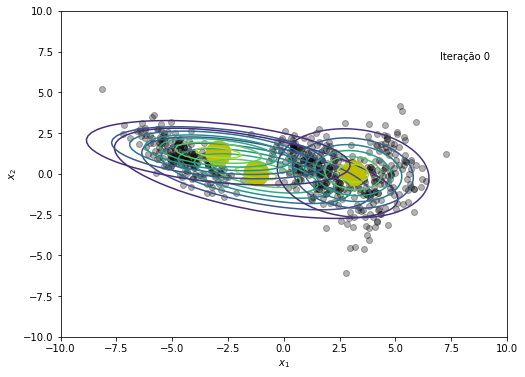

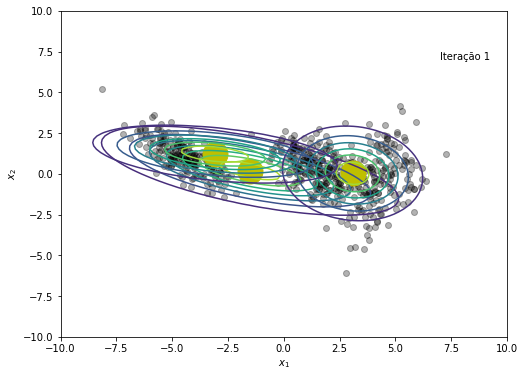

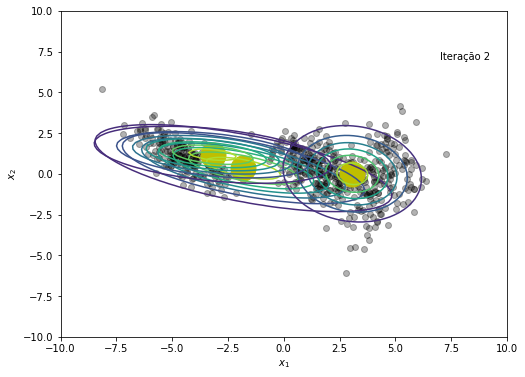

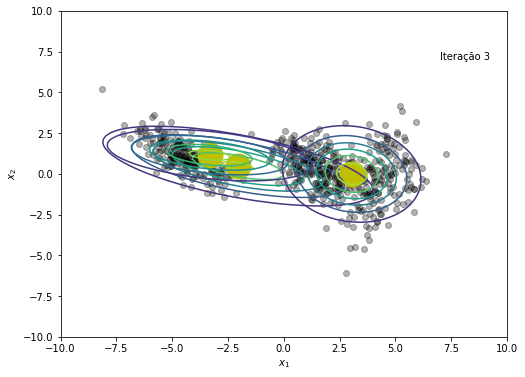

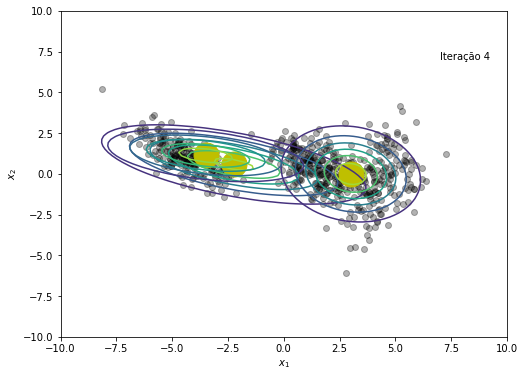

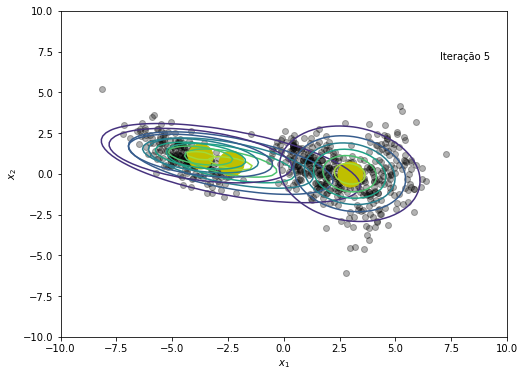

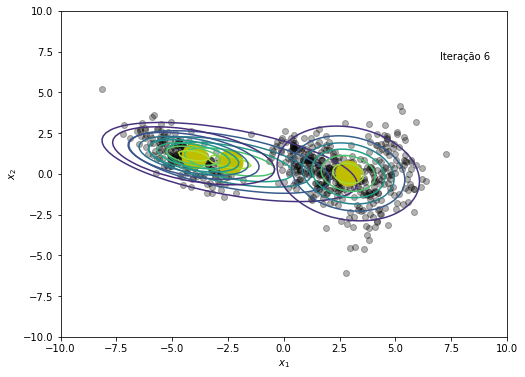

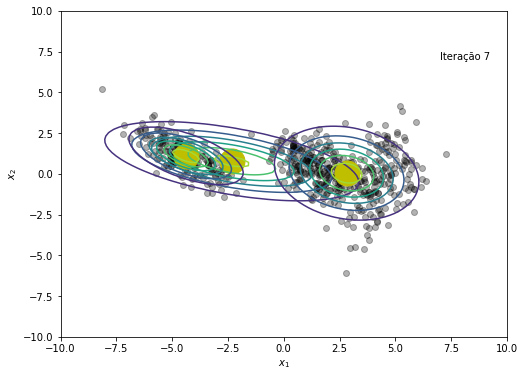

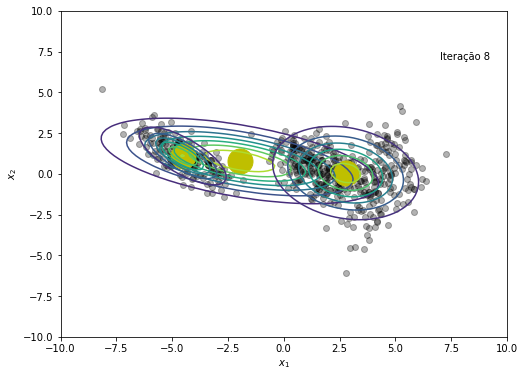

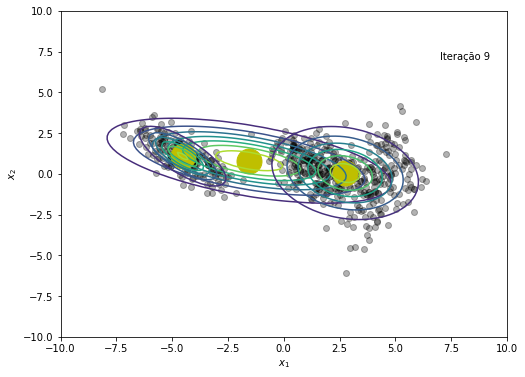

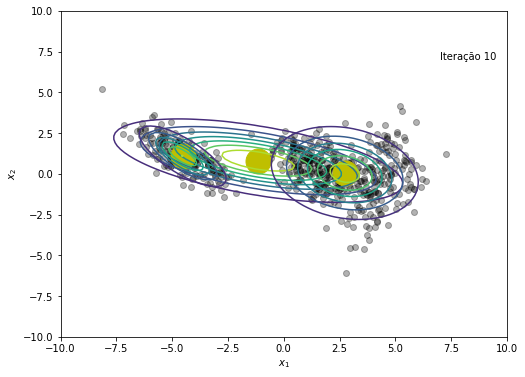

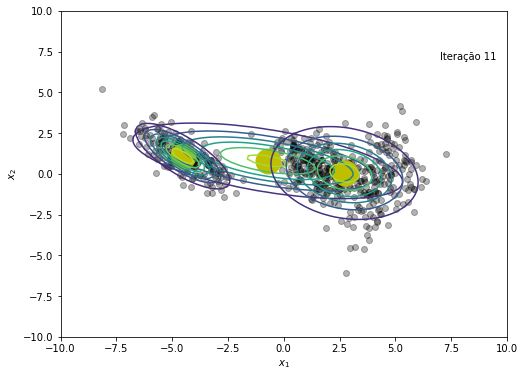

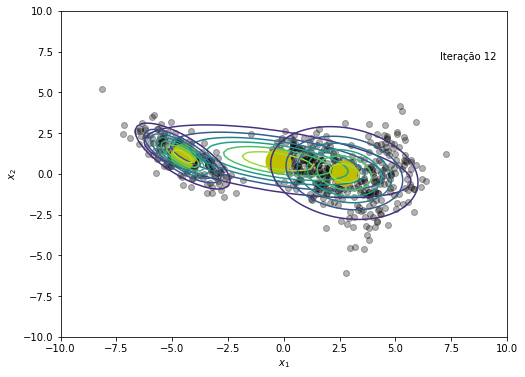

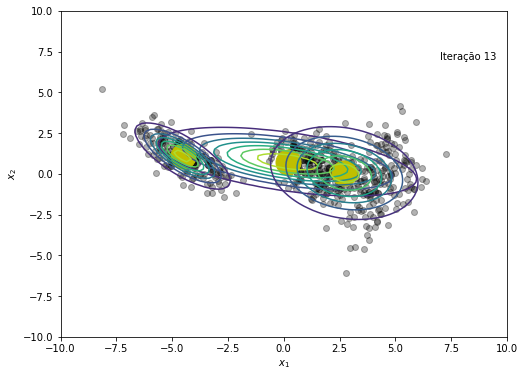

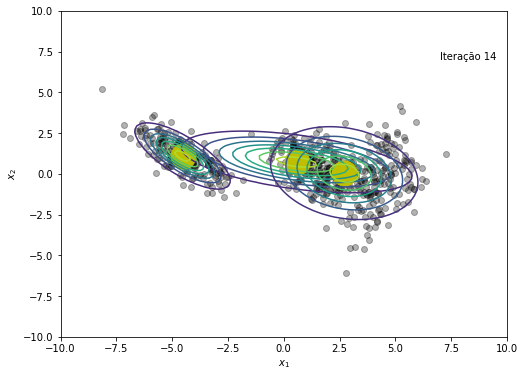

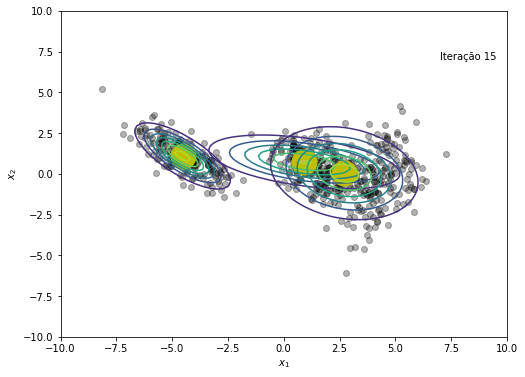

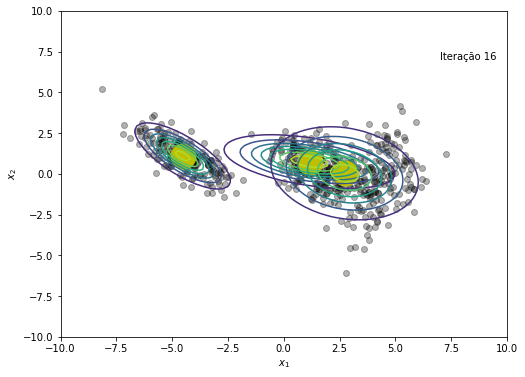

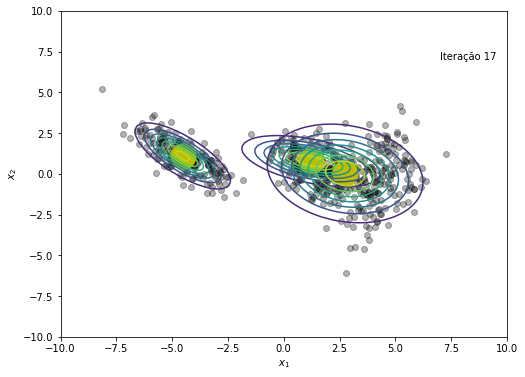

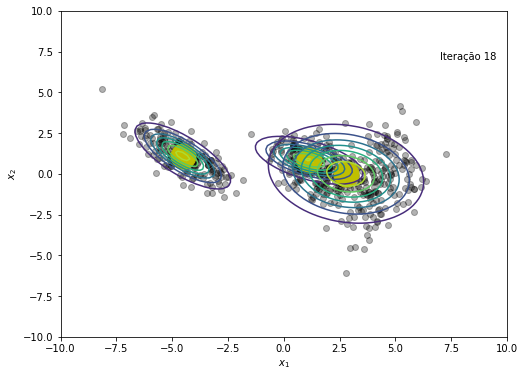

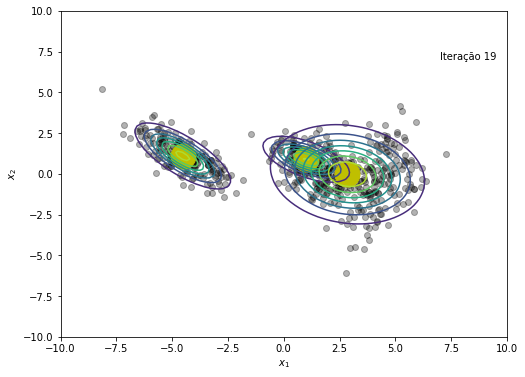

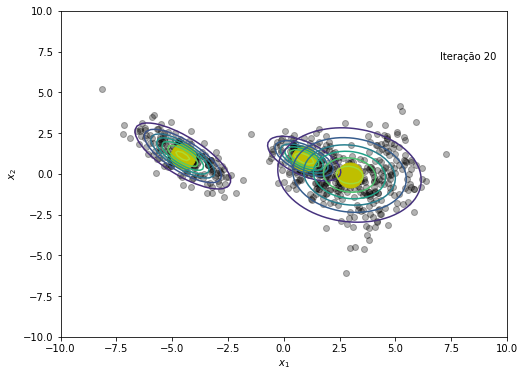

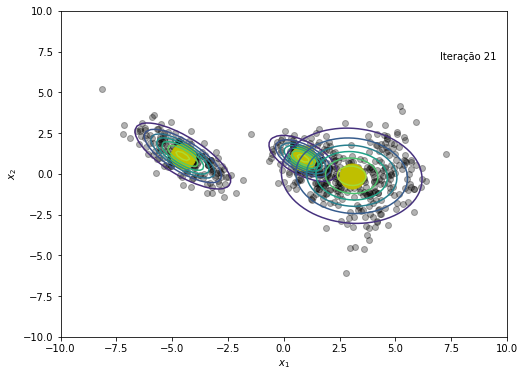

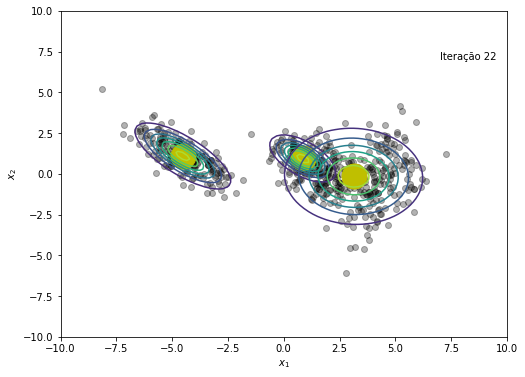

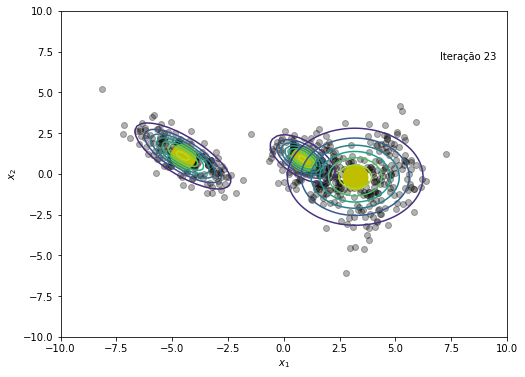

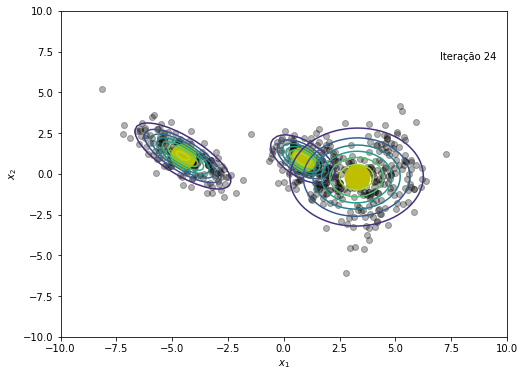

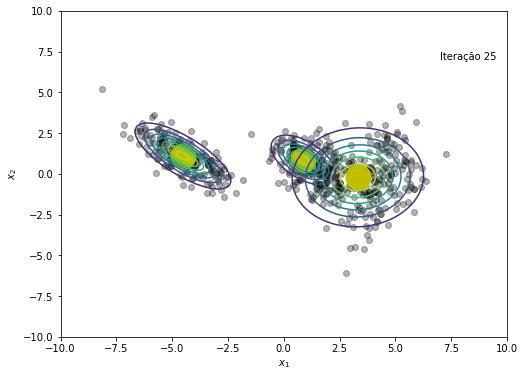

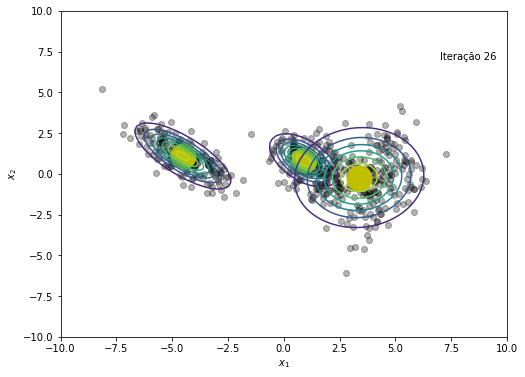

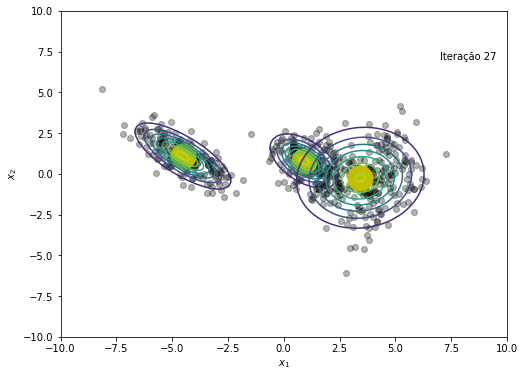

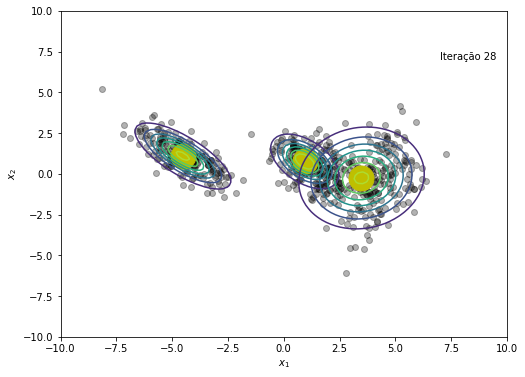

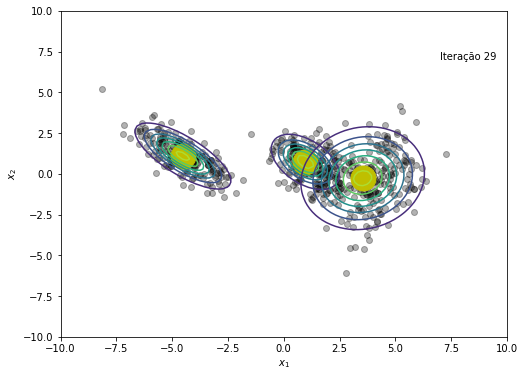

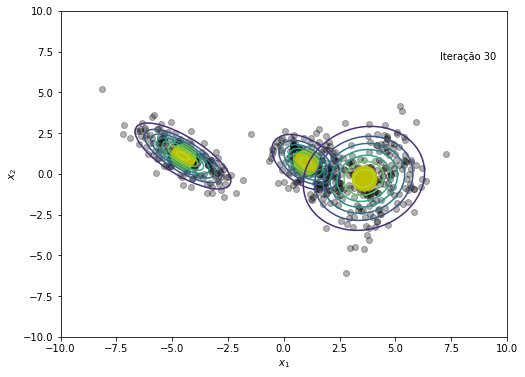

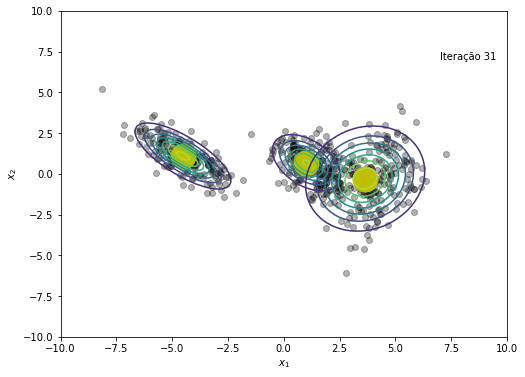

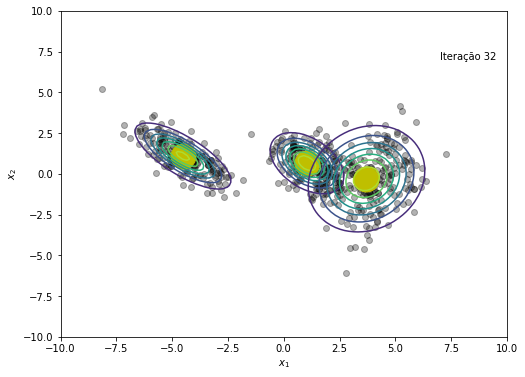

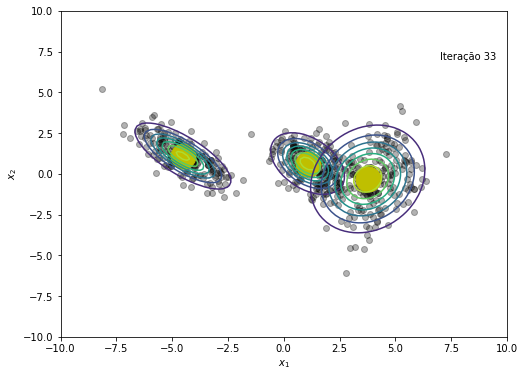

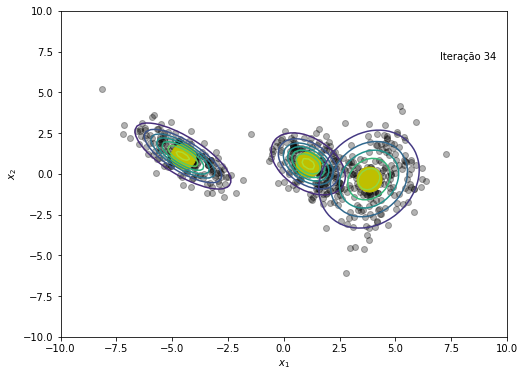

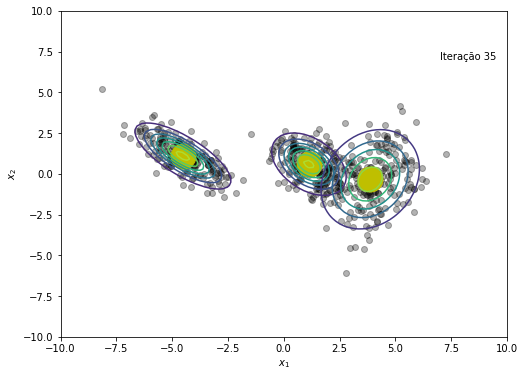

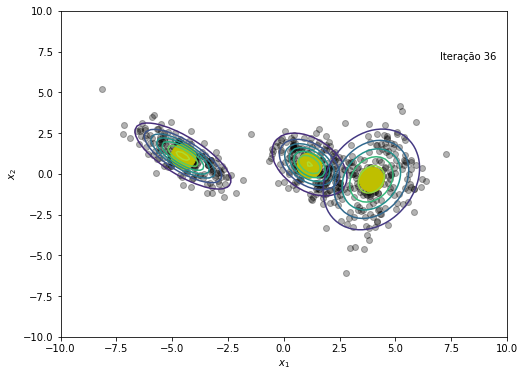

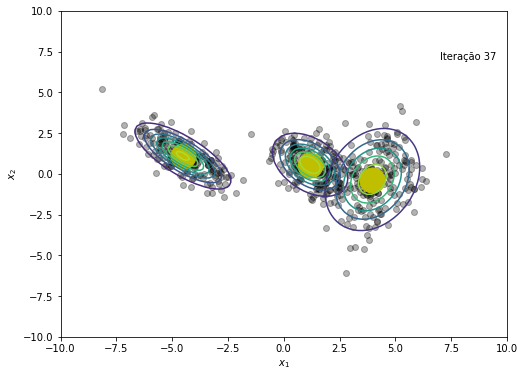

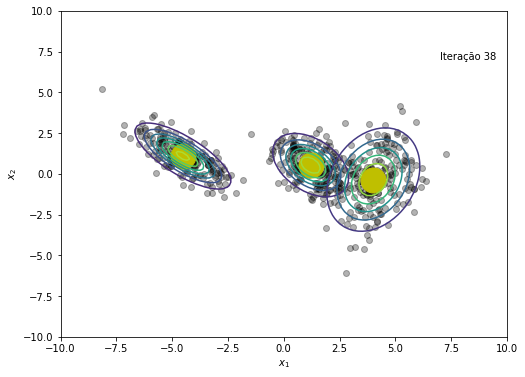

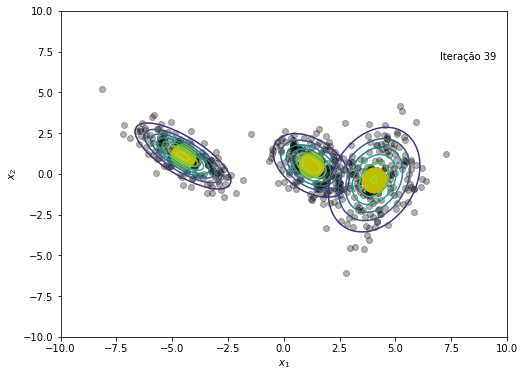

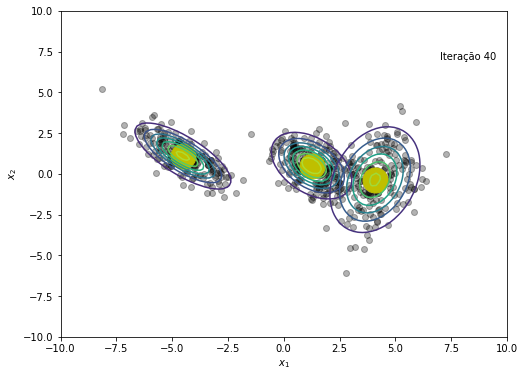

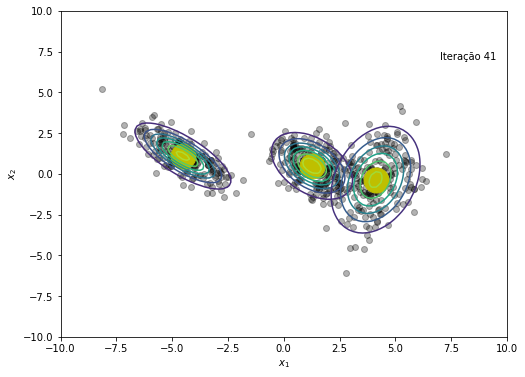

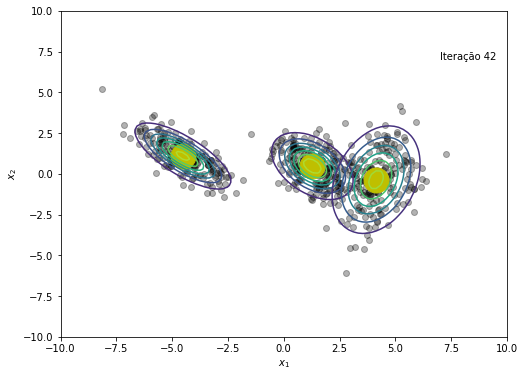

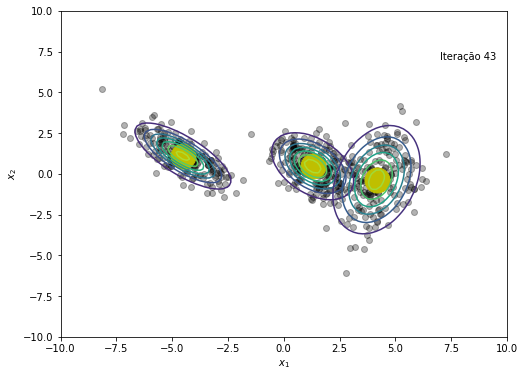

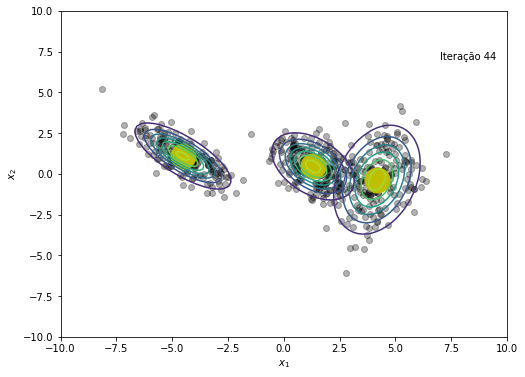

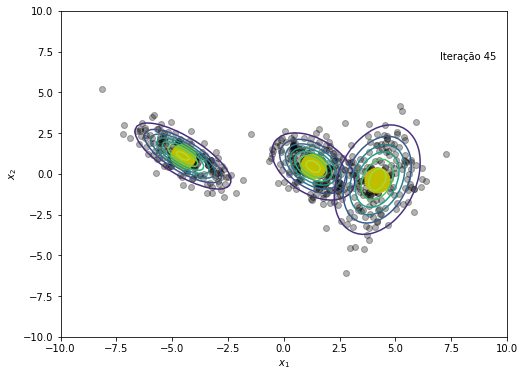

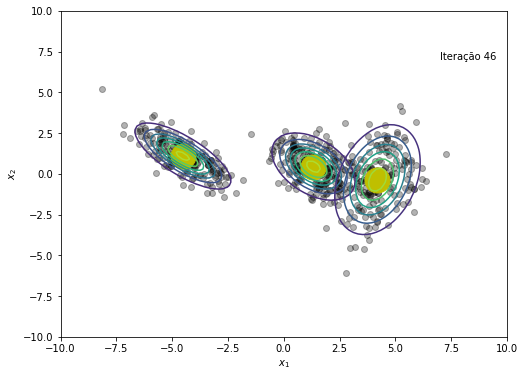

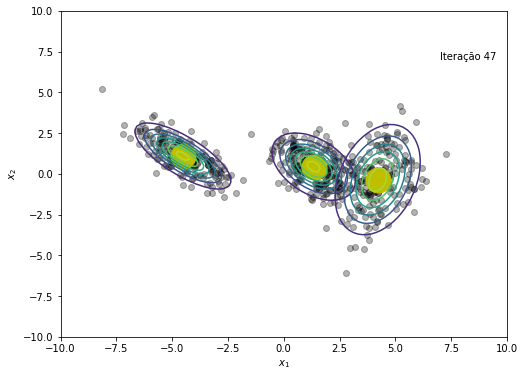

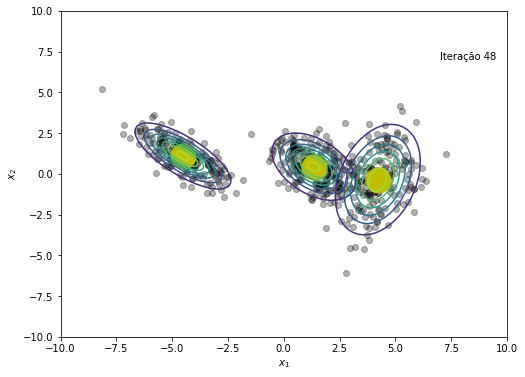

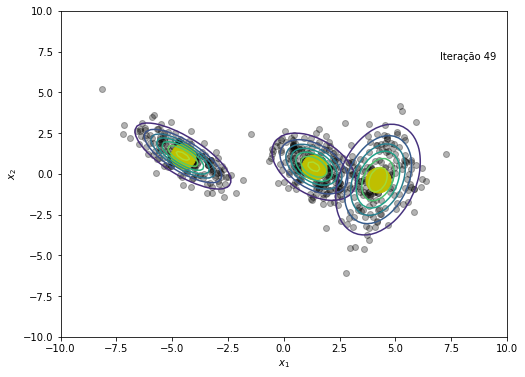

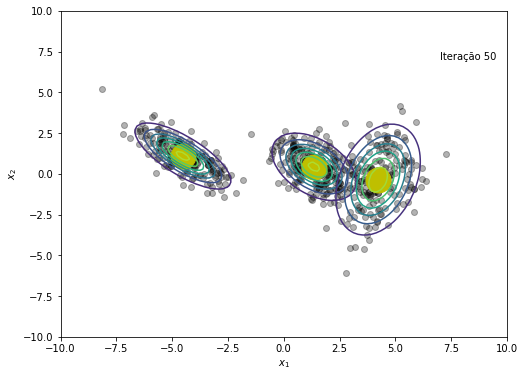

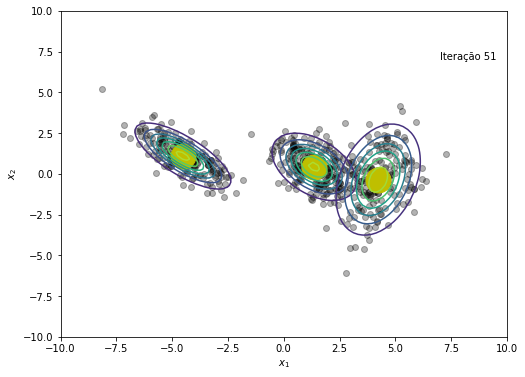

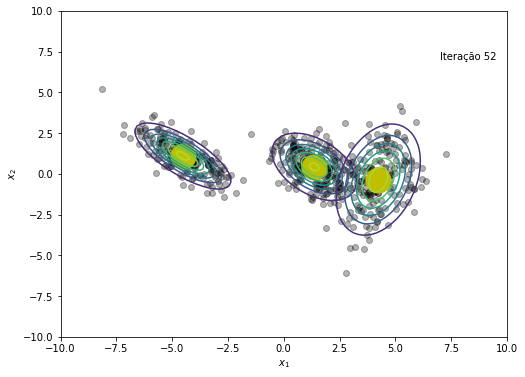

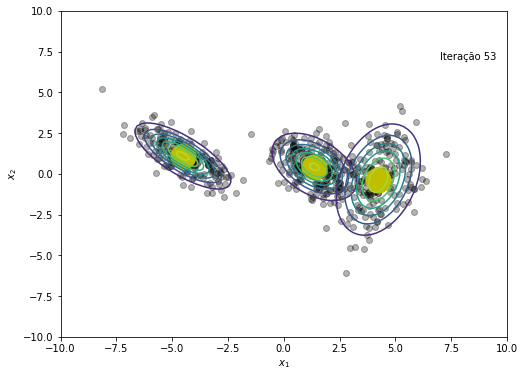

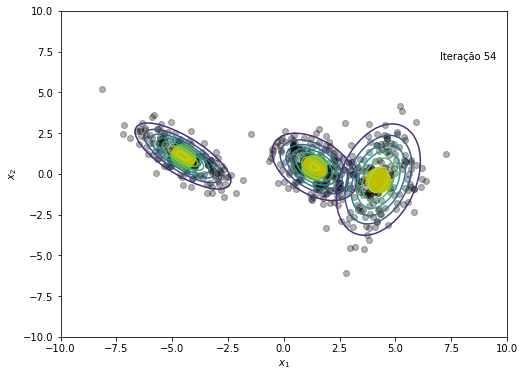

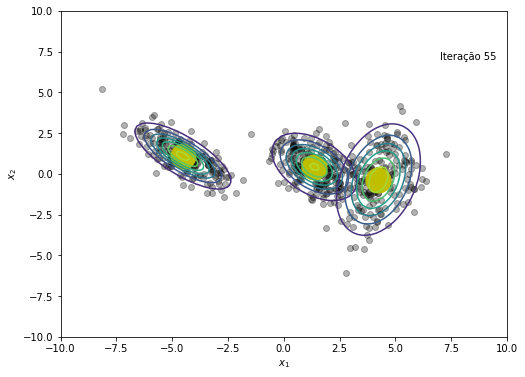

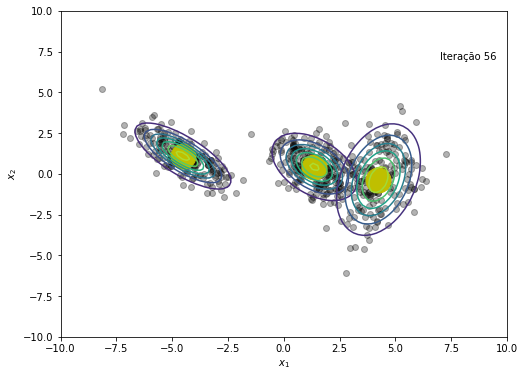

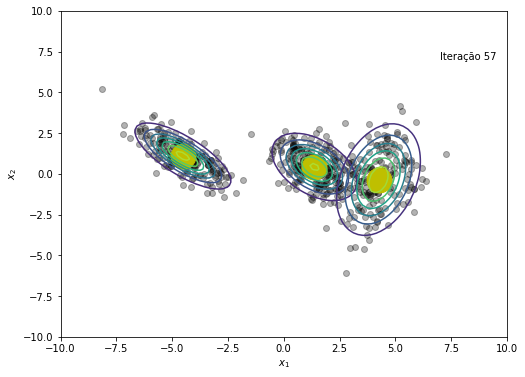

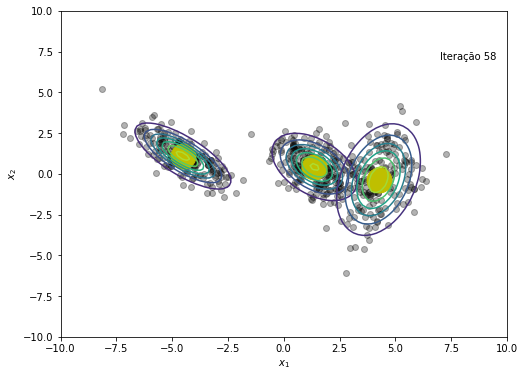

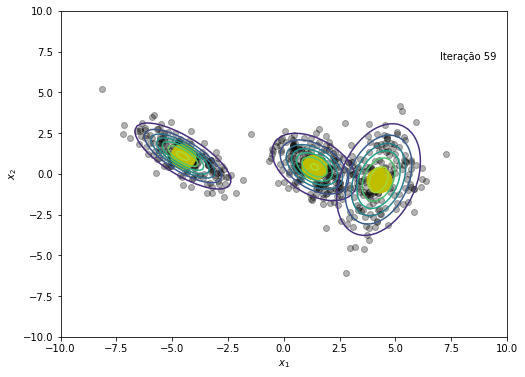

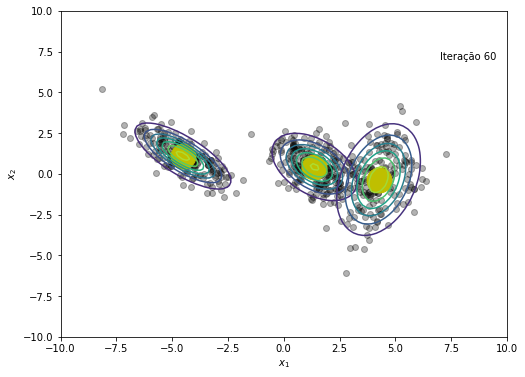

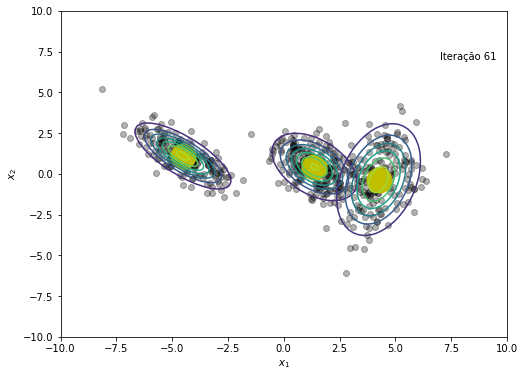

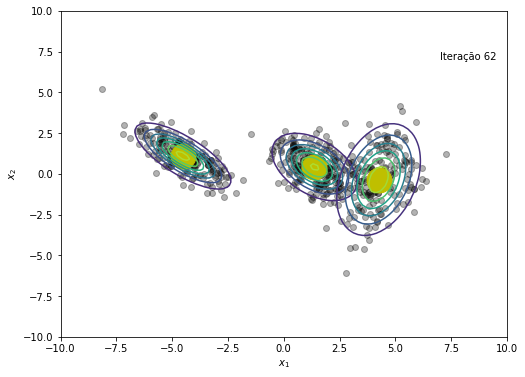

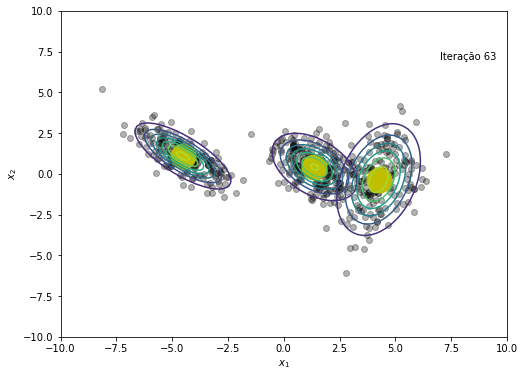

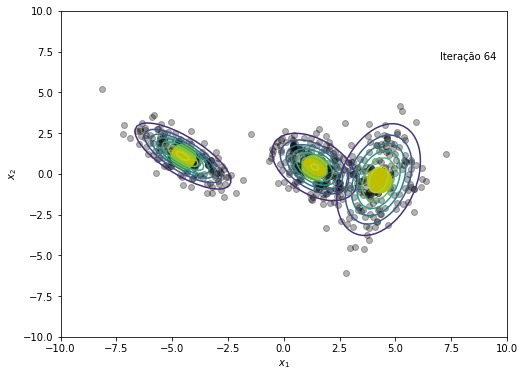

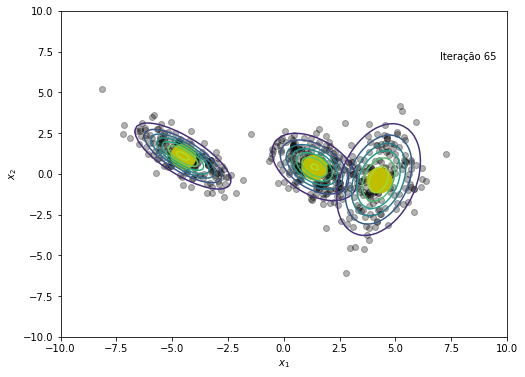

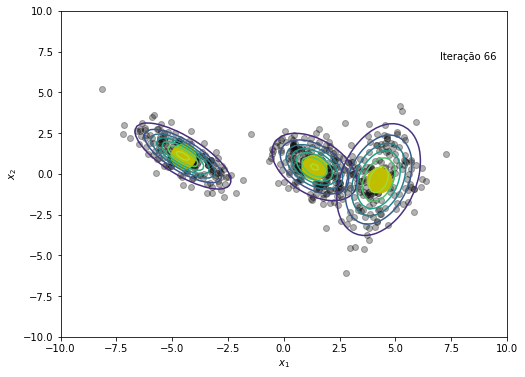

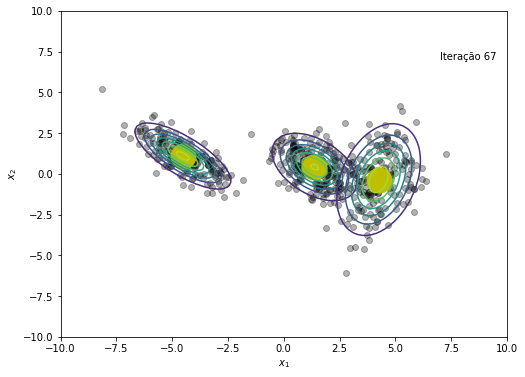

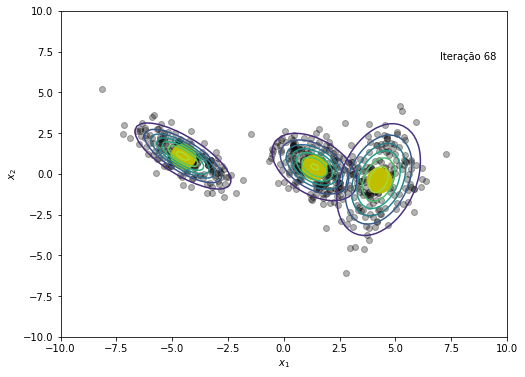

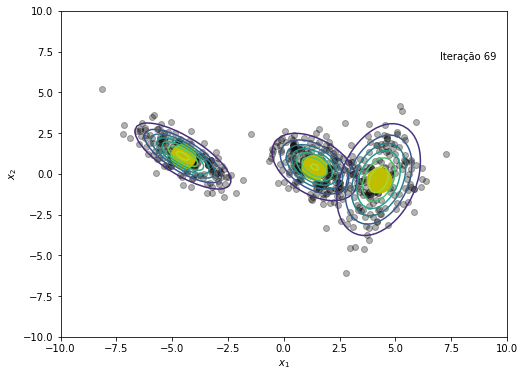

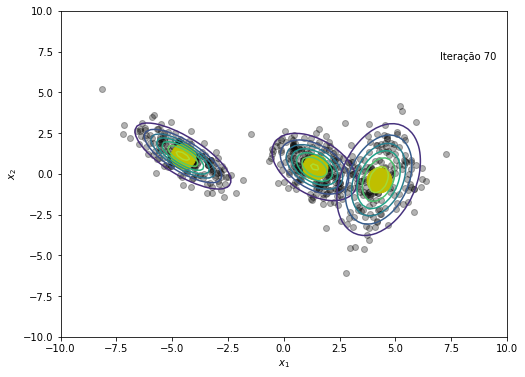

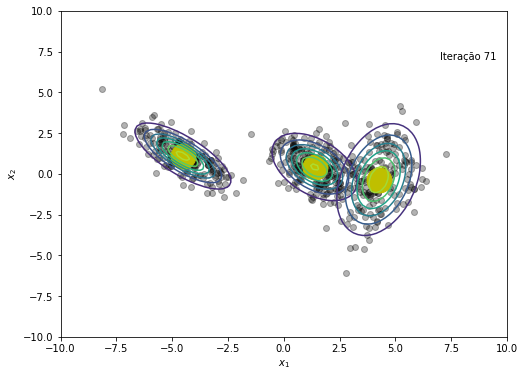

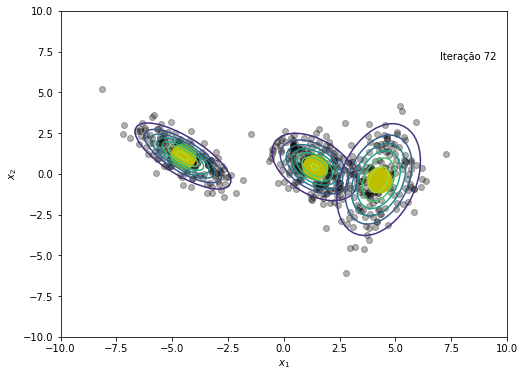

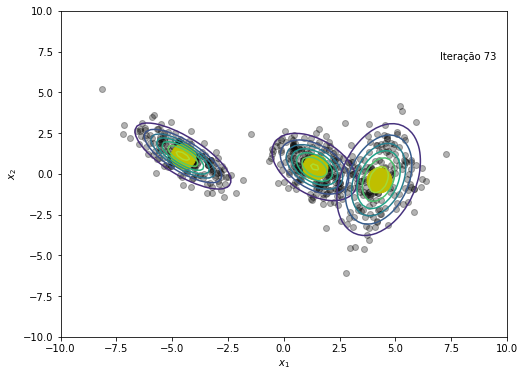

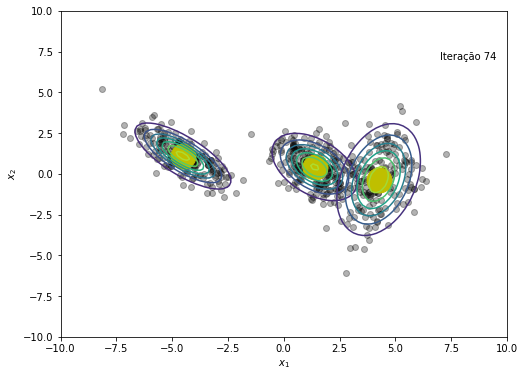

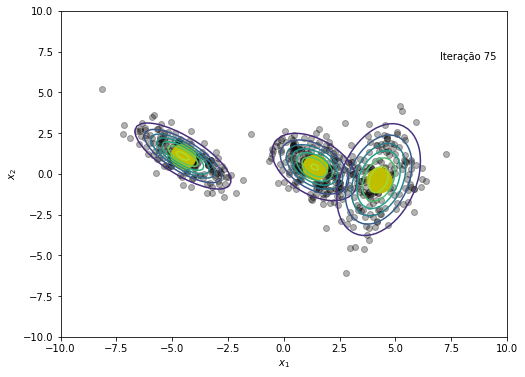

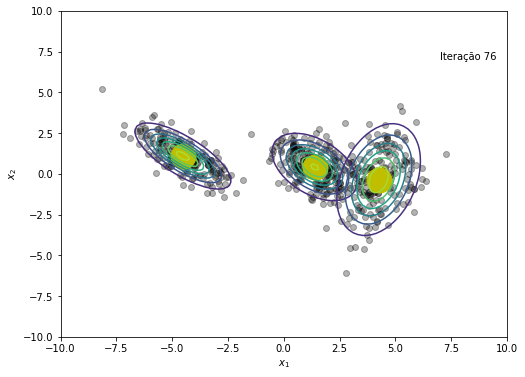

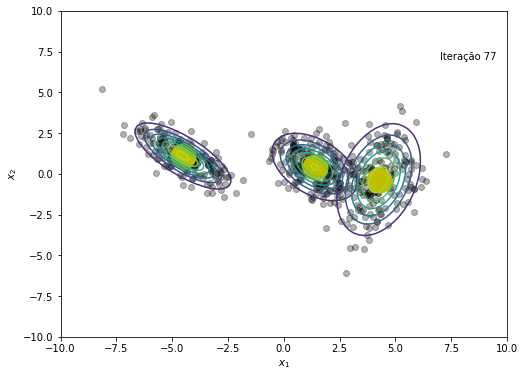

O modelo convergiu após a iteração 78


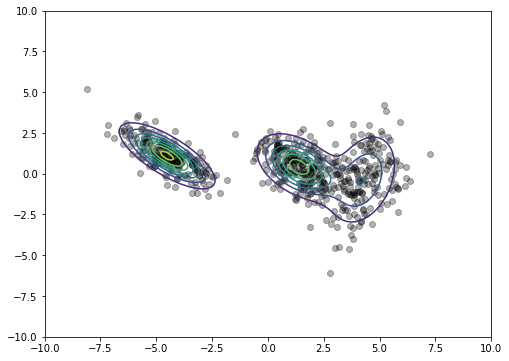

In [9]:
gama = np.zeros((K, N))  # Armazena as responsabilidades

for em_iter in range(n_interacoes):
    medias_antigo = medias.copy()

    # Etapa E - Calcular as expectativas
    for k in range(K):
        gama[k] = pesos[k]*multivariate_normal.pdf(mean=medias[k,:], cov=covs[k,:,:], x=data.T)
    gama /= np.sum(gama, axis=0)

    # Etapa M - Atualizar parâmetros
    N_k = np.sum(gama, axis=1)

    for k in range(K):
        # Atualizando médias
        medias[k] = np.sum(gama[k]*data, axis=1)/N_k[k]

        # Atualizando covariâncias
        diff = data - medias[k:k+1].T
        _temp = np.sqrt(gama[k:k+1])*diff
        covs[k] = np.inner(_temp, _temp)/N_k[k]

    # Atualizando pesos
    pesos = N_k/N

    # Calculando erro - vizinha logaritmica
    gmm_nll = 0 
    for k in range(K):
        gmm_nll += pesos[k]*multivariate_normal.pdf(mean=medias[k,:].ravel(), cov=covs[k,:,:], x=data.T)
    NLL += [-np.sum(np.log(gmm_nll))]

    # Salvando cada iteração para criar gif no final
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, 'ko', alpha=0.3)
    plt.plot(medias[:,0], medias[:,1], 'oy', markersize=25)

    for k in range(K):
        rv = multivariate_normal(medias[k,:], cov=covs[k])
        plt.contour(X, Y, rv.pdf(pos), alpha=1.0, zorder=10)
    
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.text(x=7, y=7, s=f'Iteração {em_iter}')
    plt.savefig(f'{em_iter}.png')
    plt.show()
    

    # Verificando convergência - erro = 1e-6
    if norm(NLL[em_iter+1] - NLL[em_iter]) < 1e-6:
        print(f'O modelo convergiu após a iteração {em_iter+1}')
        break
    
# Plotando o Modelo de Mistura de Gaussianas final
plt.figure(figsize=(8, 6))
gmm = 0
for k in range(K):
    mix = multivariate_normal(medias[k,:].ravel(), covs[k,:,:])
    gmm += pesos[k]*mix.pdf(pos)

plt.plot(x, y, 'ko', alpha=0.3)
plt.contour(X, Y, gmm, alpha=1.0, zorder=10)
plt.show()

In [16]:
em_iter = 51

In [17]:
# Criando gif
import imageio
import os

filenames = []
for i in range(em_iter):
    # create file name and append it to a list
    filename = f'{i}.png'
    filenames.append(filename)

# build gif
with imageio.get_writer('gaussians.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

![Gaussianas](https://media1.giphy.com/media/fpwKijmdI4xGLBUrMU/giphy.gif?cid=790b76114e3330ebde1186ac20b8c3b8a641d5cf5e3ccdf4&rid=giphy.gif&ct=g)